In [1]:
import numpy as np
from flowrec.utils.system import set_gpu
set_gpu(0,0.7)
import jax
import jax.numpy
from matplotlib import pyplot as plt
plt.style.use('./flowrec/utils/ppt.mplstyle')
from pathlib import Path
import jax.numpy as jnp

In [2]:
from flowrec.utils.simulation import read_data_volvo
import flowrec.physics_and_derivatives as derivatives
import flowrec.losses as losses
from flowrec.data import DataMetadata, normalise, unnormalise_group
from flowrec.utils.py_helper import slice_from_tuple

In [3]:
u_p, d, re, density = read_data_volvo('./local_data/volvorig/u166', nondimensional=True)
u_p.shape

(493, 40, 20, 20, 4)

In [4]:
datainfo = DataMetadata(
    re=re,
    discretisation=d,
    axis_index=[0,1,2,3],
    problem_2d=False,
).to_named_tuple()
datainfo

_Metadata3d(re=45272.49849853186, discretisation=(0.10374418999999165, 0.03205128205128194, 0.02631578947368436, 0.031578947368421026), axis_index=(0, 1, 2, 3), axt=0, axx=1, axy=2, axz=3, dt=0.10374418999999165, dx=0.03205128205128194, dy=0.02631578947368436, dz=0.031578947368421026)

# Slice: Load data and measurements

In [5]:
n_train = 200
u_train = u_p[:n_train,...]

In [6]:
z_plane = 10
y_skip = 1
inns_loc = np.s_[:,0:1,::y_skip,:,-1]
inns = u_train[inns_loc]
inns_shape = inns.shape
print(inns_shape)
inns = np.squeeze(inns)
y_loc = np.s_[:,:,:,z_plane,:-1]
y = u_train[y_loc]
print(inns.shape, y.shape)

(200, 1, 20, 20)
(200, 20, 20) (200, 40, 20, 3)


In [7]:
measured = np.empty_like(u_train)
measured[inns_loc] = inns.reshape(inns_shape)
measured[y_loc] = y
print(measured.shape)

(200, 40, 20, 20, 4)


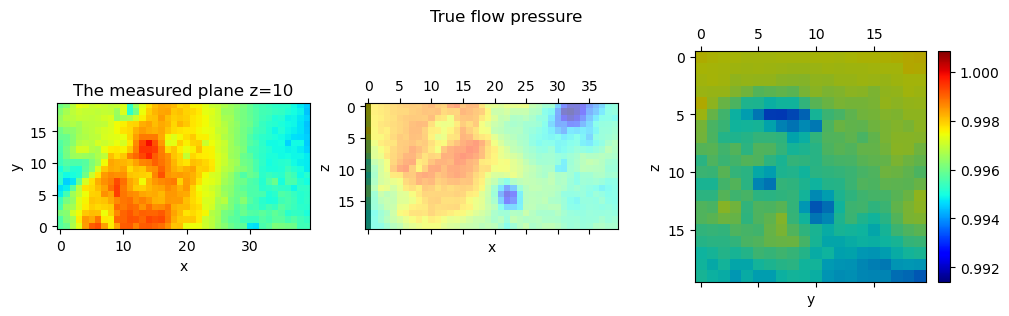

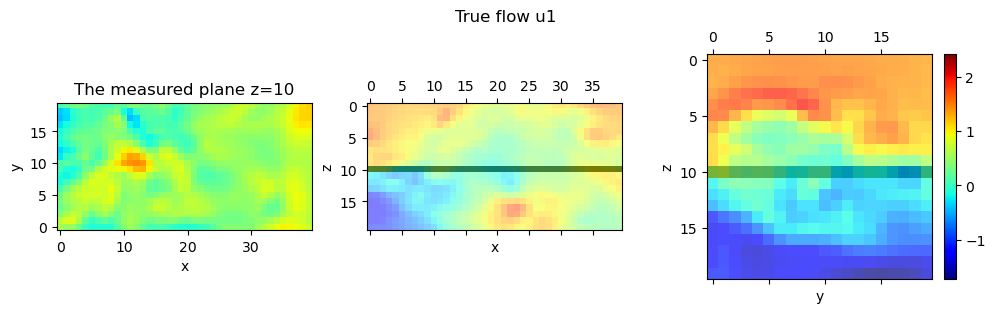

In [8]:
plt_t = 10
vmin = u_train[plt_t,...,-1].min()
vmax = u_train[plt_t,...,-1].max()
fig, axes = plt.subplots(1, 3, figsize=(10,3))
axes[0].set_title(f'The measured plane z={z_plane}')
axes[0].imshow(u_train[plt_t,:,:,z_plane,-1].T, vmin=vmin, vmax=vmax)
axes[0].set(xlabel='x', ylabel='y')
axes[1].imshow(u_train[plt_t,:,0,:,-1].T, vmin=vmin, vmax=vmax)
axes[1].spy(measured[plt_t,:,0,:,-1].T,alpha=0.5)
axes[1].set(xlabel='x', ylabel='z')
imyz = axes[2].imshow(u_train[plt_t,0,:,:,-1].T, vmin=vmin, vmax=vmax)
axes[2].spy(measured[plt_t,0,:,:,-1].T,alpha=0.3)
axes[2].set(xlabel='y', ylabel='z')
plt.colorbar(imyz)
fig.suptitle('True flow pressure')
plt.show()
vmin = u_train[plt_t,...,0].min()
vmax = u_train[plt_t,...,0].max()
fig, axes = plt.subplots(1, 3, figsize=(10,3))
axes[0].set_title(f'The measured plane z={z_plane}')
axes[0].imshow(u_train[plt_t,:,:,z_plane,0].T, vmin=vmin, vmax=vmax)
axes[0].set(xlabel='x', ylabel='y')
axes[1].imshow(u_train[plt_t,:,0,:,0].T, vmin=vmin, vmax=vmax)
axes[1].spy(measured[plt_t,:,0,:,0].T,alpha=0.5)
axes[1].set(xlabel='x', ylabel='z')
imyz = axes[2].imshow(u_train[plt_t,0,:,:,0].T, vmin=vmin, vmax=vmax)
axes[2].spy(measured[plt_t,0,:,:,0].T,alpha=0.3)
axes[2].set(xlabel='y', ylabel='z')
plt.colorbar(imyz)
fig.suptitle('True flow u1')
plt.show()

In [9]:
ld_ref = losses.divergence(u_train[...,:-1],datainfo)
lm_ref = losses.momentum_loss(u_train, datainfo)
print('Div and momentum loss ',ld_ref, lm_ref)

Div and momentum loss  1.3808253 74.10478


### Test Poisson equation for pressure

In [11]:
d2pdx1 = derivatives.derivative2(u_train[...,-1], h=datainfo.dx, axis=datainfo.axx)
d2pdx2 = derivatives.derivative2(u_train[...,-1], h=datainfo.dy, axis=datainfo.axy)
d2pdx3 = derivatives.derivative2(u_train[...,-1], h=datainfo.dz, axis=datainfo.axz)
dp2 = d2pdx1+d2pdx2+d2pdx3
dp2.shape

(200, 40, 20, 20)

In [12]:
d1_over_u = jax.vmap(derivatives.derivative1, (4,None,None),4)
_duidx1 = d1_over_u(u_train[...,:-1],datainfo.dx,datainfo.axx) # [t...i](d_dx1)
_duidx2 = d1_over_u(u_train[...,:-1],datainfo.dy,datainfo.axy) # [t...i](d_dx2)
_duidx3 = d1_over_u(u_train[...,:-1],datainfo.dz,datainfo.axz) # [t...i](d_dx3)
duidxj = jnp.stack((_duidx1, _duidx2, _duidx3), axis=5) # [txyzij]
uj_duidxj = jnp.einsum('...j, ...ij -> ...i', u_train[...,:-1], duidxj)
print(uj_duidxj.shape)

(200, 40, 20, 20, 3)


In [13]:
udu1dx_dx1 = derivatives.derivative2(uj_duidxj[...,0], h=datainfo.dx, axis=datainfo.axx)
udu2dx_dx2 = derivatives.derivative2(uj_duidxj[...,1], h=datainfo.dy, axis=datainfo.axy)
udu3dx_dx3 = derivatives.derivative2(uj_duidxj[...,2], h=datainfo.dz, axis=datainfo.axz)
div_ududx = udu1dx_dx1+udu2dx_dx2+udu3dx_dx3
print(div_ududx.shape)

(200, 40, 20, 20)


In [14]:
print(losses.mse(div_ududx + dp2))
print(div_ududx + dp2)

113674136.0
[[[[-9.46899316e+03 -2.88443438e+04  6.24049438e+02 ... -1.15412900e+04
    -1.00052061e+04  3.76263711e+04]
   [ 6.28611621e+03 -2.89490723e+04 -1.31369512e+04 ...  8.54470117e+03
     9.03925684e+03  2.80568145e+04]
   [ 5.58693848e+03 -3.34994297e+04 -1.34157979e+04 ... -5.39020898e+03
    -1.07215820e+04 -4.87804180e+04]
   ...
   [ 1.51605674e+04  2.27149121e+04  4.07788242e+04 ... -1.19533984e+03
     1.07919082e+04  1.60181240e+04]
   [ 1.47173401e+02 -2.17890117e+04  1.05332627e+04 ... -3.41675024e+03
    -1.16613037e+03  1.46566055e+04]
   [ 2.60575488e+03 -5.13467734e+04 -3.01222383e+04 ... -5.05795212e+01
    -3.44389740e+02 -9.17180566e+03]]

  [[ 4.00075312e+04 -2.90201973e+04 -4.03125469e+04 ... -3.64234814e+03
    -2.16896973e+04  6.55137451e+03]
   [ 3.03613457e+04 -3.32646211e+04 -7.36893896e+03 ... -3.59433838e+03
    -7.80797852e+03 -2.90660000e+04]
   [ 1.47362236e+04 -1.88902617e+04 -8.19641113e+03 ...  1.08952747e+03
    -1.29739736e+04 -5.36891914e+04

# Model

In [15]:
import flowrec.training_and_states as train
import optax
from train_config.train_options import optimizer as optimiser_options

In [16]:
key = jax.random.PRNGKey(10)

Normalise data

In [67]:
# [inns_norm], inns_range = normalise(inns, range=[[inns[:,:,z_plane].min(),inns[:,:,z_plane].max()]])
[inns_norm], inns_range = normalise(inns)
y_list, y_range = normalise(y[...,0],y[...,1],y[...,2])
y_norm = np.stack(y_list, axis=-1)
print(y_norm.shape)
refvelocity_norm, _ = normalise(u_train[...,0],u_train[...,1],u_train[...,2], range=y_range)
refvelocity_norm = np.stack(refvelocity_norm, axis=-1)
all_range = y_range.copy()
all_range.extend(inns_range)
print(all_range)
u_train_norm,_ = normalise(*[np.squeeze(_u) for _u in np.split(u_train,4, axis=-1)], range=all_range)
u_train_norm = np.stack(u_train_norm, axis=-1)

(200, 40, 20, 3)
[array([-2.0598397,  2.4750676], dtype=float32), array([-2.0580072,  1.8241131], dtype=float32), array([-2.666058,  2.500734], dtype=float32), array([0.9853492, 1.0020655], dtype=float32)]


## train on slices

In [14]:
from flowrec.models.feedforward import Model as FFMDL
from flowrec.models.feedforward import MLP

In [15]:
mdl1 = FFMDL(
    layers=[128,256, 512, 1024,y[0,...].size],
)

In [16]:
lr = 0.0001

In [17]:
params1 = mdl1.init(key,inns_norm[:10,:,z_plane])
scheduler1 = optimiser_options.get_scheduler('exponential_decay', lr)
optimiser1 = optax.adamw(learning_rate=scheduler1)
opt_state1 = optimiser1.init(params1)
state1 = train.TrainingState(params=params1, opt_state=opt_state1)
mdl1.apply(state1.params, key, inns_norm[:10,:,z_plane]).shape

(10, 2400)

In [18]:
hist1 = []
best_l = jnp.inf

In [19]:
update1 = train.generate_update_fn(
    mdl1.apply,
    optimiser1,
    losses.loss_mse,
)
_l, _ = update1(state1, key, inns_norm[:10,:,z_plane], y_norm[:10,...].reshape((10,-1)))
print(_l)

0.08051046


epoch 0, loss 0.08195074647665024
epoch 20, loss 0.05356358736753464
epoch 40, loss 0.04330386221408844
epoch 60, loss 0.042680948972702026
epoch 80, loss 0.04224388673901558
epoch 100, loss 0.04185180366039276
epoch 120, loss 0.041481129825115204
epoch 140, loss 0.04112724959850311
epoch 160, loss 0.04079475253820419
epoch 180, loss 0.04049168899655342
epoch 200, loss 0.040213584899902344
epoch 220, loss 0.039947509765625
epoch 240, loss 0.039680831134319305
epoch 260, loss 0.03940413519740105
epoch 280, loss 0.03911617398262024
epoch 300, loss 0.03883025422692299
epoch 320, loss 0.038553666323423386
epoch 340, loss 0.03837946057319641
epoch 360, loss 0.038174163550138474
epoch 380, loss 0.03794805705547333
epoch 400, loss 0.03778235614299774
epoch 420, loss 0.03764572739601135
epoch 440, loss 0.037516649812459946
epoch 460, loss 0.03741319850087166
epoch 480, loss 0.037297844886779785
epoch 500, loss 0.03719160705804825
epoch 520, loss 0.037089742720127106
epoch 540, loss 0.036990407

Text(0, 0.5, 'loss mse')

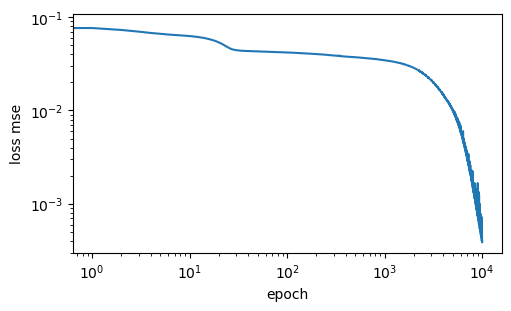

In [20]:
n_epochs = 10000
for i in range(n_epochs):
    [key] = jax.random.split(key,1)
    l_epoch = []
    j = 0
    while (j+1)*50 <= n_train :
        _l, state1 = update1(state1, key, inns_norm[j*50:(j+1)*50,:,z_plane], y_norm[j*50:(j+1)*50,...].reshape((50,-1)))
        j += 1
        l_epoch.append(_l)
    l = np.mean(l_epoch)
    hist1.append(l)
    if i % 20 == 0:
        print(f'epoch {i}, loss {l}')
    if l < best_l:
        best_state1 = state1
        best_l = l
plt.figure(figsize=(5,3))
plt.loglog(hist1)
plt.xlabel('epoch')
plt.ylabel('loss mse')

In [21]:
pred_slice_norm = mdl1.apply(best_state1.params, None, inns_norm[:,:,z_plane]).reshape(y.shape)

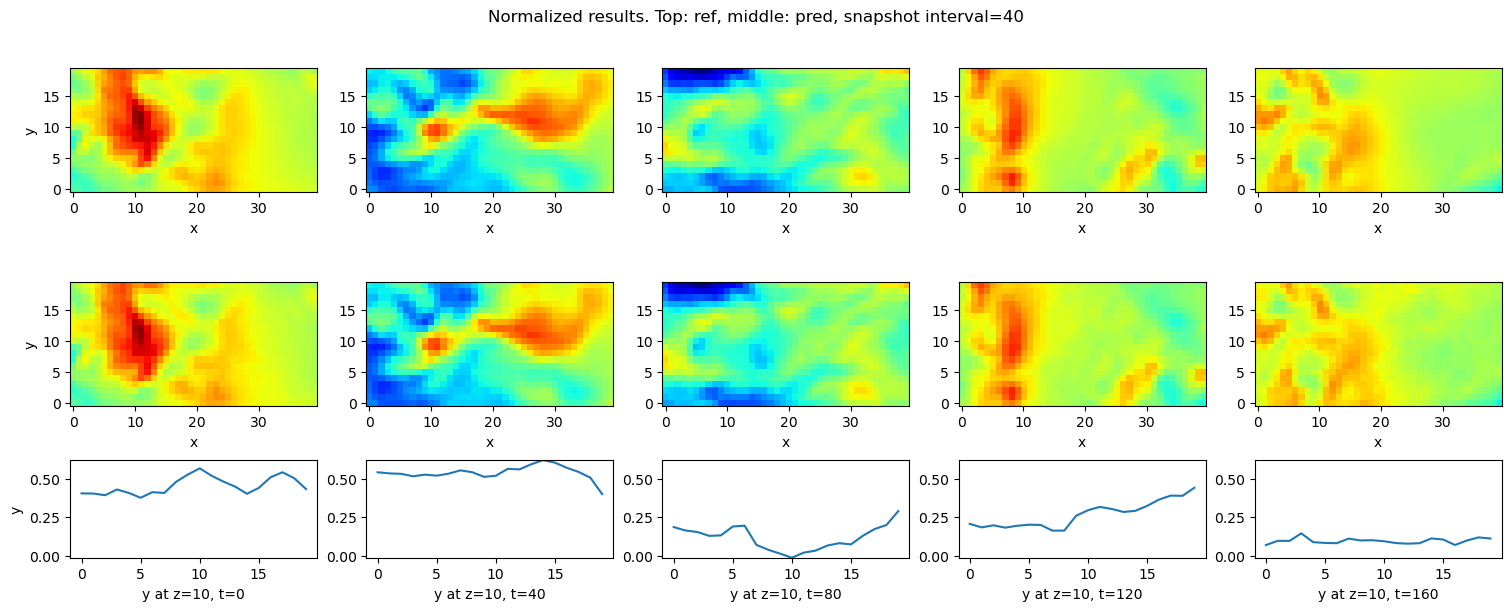

In [22]:
plt_step = 40
vmin = y_norm[::plt_step,...,0].min()
vmax = y_norm[::plt_step,...,0].max()
fig,axes = plt.subplots(3,5,figsize=(15,6),height_ratios=(0.4,0.4,0.2))
fig.suptitle(f'Normalized results. Top: ref, middle: pred, snapshot interval={plt_step}')
for i in range(5):
    axes[2,i].plot(inns_norm[i*plt_step,:,z_plane])
    axes[2,i].set(xlabel=f'y at z={z_plane}, t={i*plt_step}', ylim=[inns_norm[::plt_step,:,z_plane].min(), inns_norm[::plt_step,:,z_plane].max()])
    axes[0,i].imshow(y_norm[i*plt_step,...,0].T, vmin=vmin, vmax=vmax)
    axes[0,i].set(xlabel='x')
    axes[1,i].imshow(pred_slice_norm[i*plt_step,...,0].T, vmin=vmin, vmax=vmax)
    axes[1,i].set(xlabel='x')
axes[0,0].set_ylabel('y')
axes[1,0].set_ylabel('y')
axes[2,0].set_ylabel('y')
plt.show()

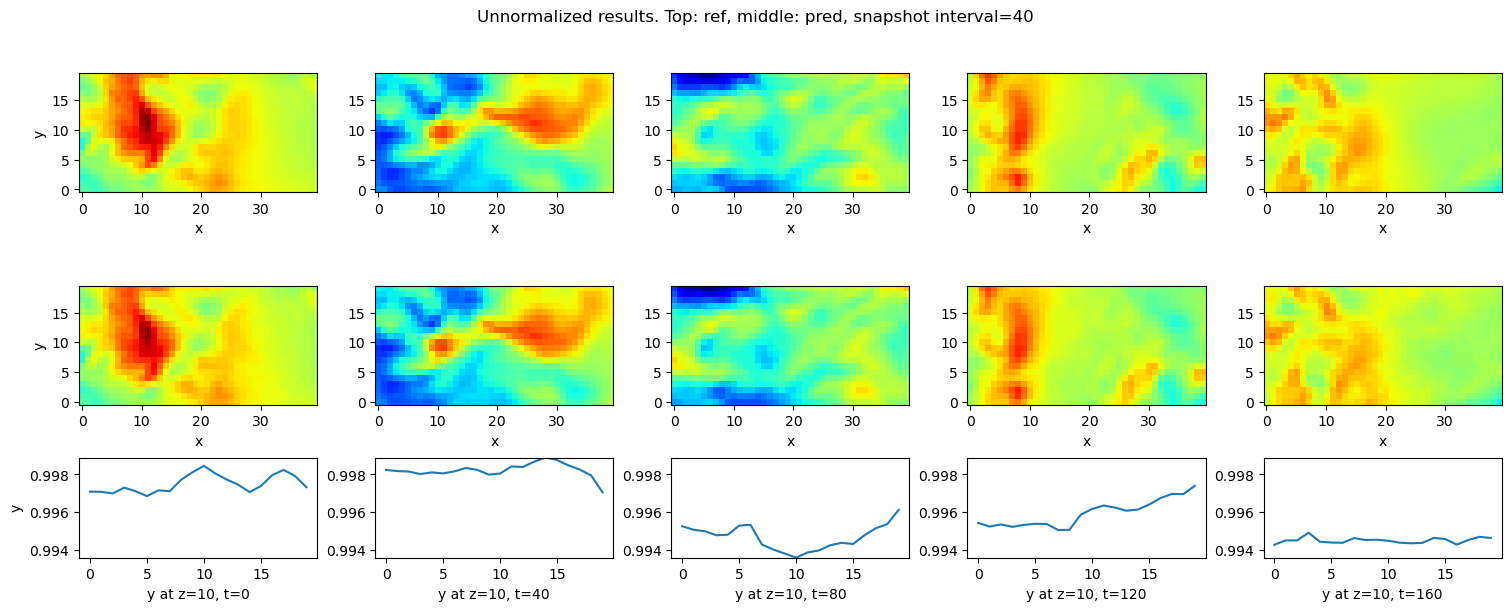

In [23]:
pred_slice = unnormalise_group(pred_slice_norm, data_range=y_range, axis_data=-1, axis_range=0)
vmin = y[::plt_step,...,0].min()
vmax = y[::plt_step,...,0].max()
fig,axes = plt.subplots(3,5,figsize=(15,6),height_ratios=(0.4,0.4,0.2))
fig.suptitle(f'Unnormalized results. Top: ref, middle: pred, snapshot interval={plt_step}')
for i in range(5):
    axes[2,i].plot(inns[i*plt_step,:,z_plane])
    axes[2,i].set(xlabel=f'y at z={z_plane}, t={i*plt_step}', ylim=[inns[::plt_step,:,z_plane].min(), inns[::plt_step,:,z_plane].max()])
    imref = axes[0,i].imshow(y[i*plt_step,...,0].T, vmin=vmin, vmax=vmax)
    # plt.colorbar(imref)
    axes[0,i].set(xlabel='x')
    impred = axes[1,i].imshow(pred_slice[i*plt_step,...,0].T, vmin=vmin, vmax=vmax)
    axes[1,i].set(xlabel='x')
    # plt.colorbar(impred)
axes[0,0].set_ylabel('y')
axes[1,0].set_ylabel('y')
axes[2,0].set_ylabel('y')
plt.show()

### Test on volume

In [24]:
mdl1_predict_overz = jax.vmap(mdl1.predict, (None,2), 2)

In [25]:
predv1_norm = mdl1_predict_overz(best_state1.params, inns_norm).reshape((*y.shape,-1))
predv1_norm = np.einsum('txyuz -> txyzu', predv1_norm)
print(f'volume mse {losses.mse(predv1_norm,refvelocity_norm)}, measured plane {losses.mse(predv1_norm[:,:,:,z_plane,:],refvelocity_norm[:,:,:,z_plane,:])}')
for i in range(0,z_plane):
    print(losses.mse(predv1_norm[:,:,:,i,:],refvelocity_norm[:,:,:,i,:]))
predv1 = unnormalise_group(predv1_norm, data_range=y_range, axis_data=-1, axis_range=0)
print(f'Divergence {losses.divergence(predv1,datainfo)}')

volume mse 0.11351843923330307, measured plane 0.0003848570631816983
0.12787646
0.12238586
0.12566645
0.12979895
0.12657854
0.11780642
0.11168636
0.10198931
0.078346014
0.052710894
Divergence 528.0176391601562


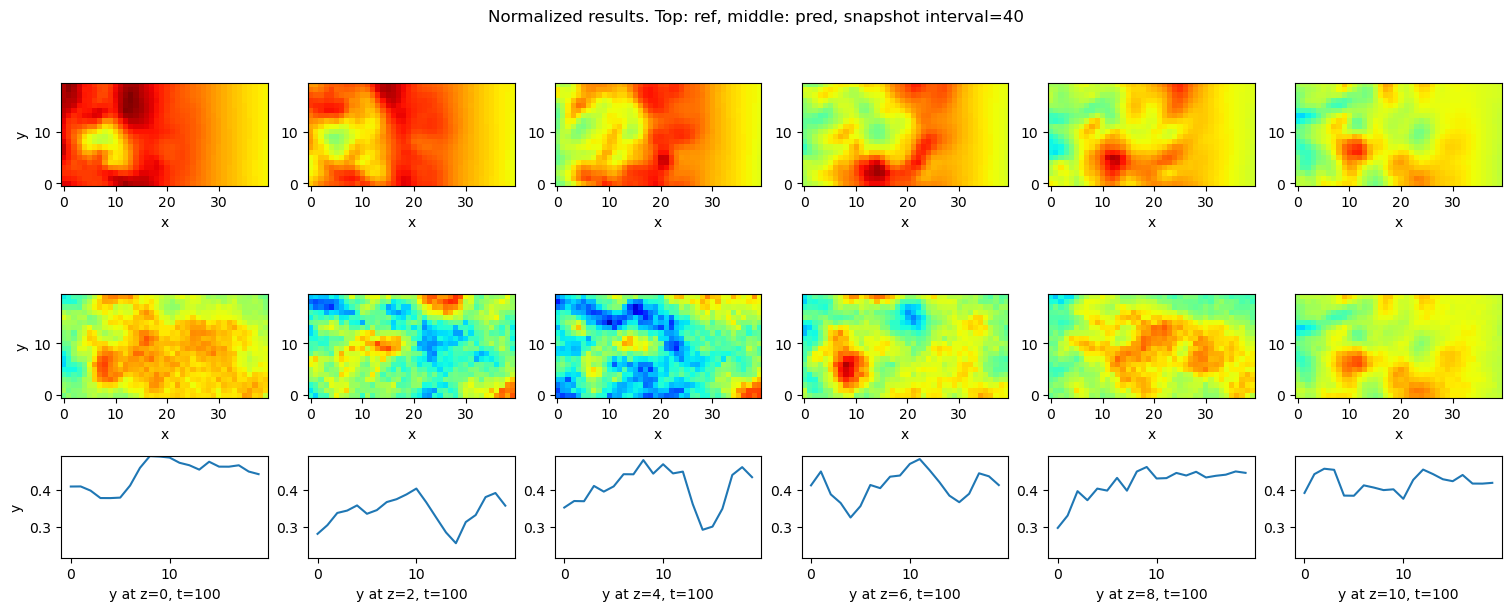

In [26]:
plt_zgap = 2
plt_t = 100
vmin = refvelocity_norm[plt_t,...,::plt_zgap,0].min()
vmax = refvelocity_norm[plt_t,...,::plt_zgap,0].max()
fig,axes = plt.subplots(3,6,figsize=(15,6),height_ratios=(0.4,0.4,0.2))
fig.suptitle(f'Normalized results. Top: ref, middle: pred, snapshot interval={plt_step}')
for i in range(6):
    axes[2,i].plot(inns_norm[plt_t,:,i*plt_zgap])
    axes[2,i].set(xlabel=f'y at z={i*plt_zgap}, t={plt_t}', ylim=[inns_norm[plt_t,:,::plt_zgap].min(), inns_norm[plt_t,:,::plt_zgap].max()])
    axes[0,i].imshow(refvelocity_norm[plt_t,:,:,i*plt_zgap,0].T, vmin=vmin, vmax=vmax)
    axes[0,i].set(xlabel='x')
    axes[1,i].imshow(predv1_norm[plt_t,:,:,i*plt_zgap,0].T, vmin=vmin, vmax=vmax)
    axes[1,i].set(xlabel='x')
axes[0,0].set_ylabel('y')
axes[1,0].set_ylabel('y')
axes[2,0].set_ylabel('y')
plt.show()

## Train on volume 

### Correct for z locations

In [27]:
import haiku as hk

v_resize = jax.vmap(jax.tree_util.Partial(jax.image.resize,method='linear'),(-1,None),-1)
vv_resize = jax.vmap(v_resize,(0,None),0)
[key] = jax.random.split(key,1)

In [418]:
def forward3(x,p,z_coord):
    l1 = hk.Conv2D(4,3)
    l2 = hk.Conv2D(8,3)
    l3 = [hk.Linear(n) for n in [50,10]]
    l4 = [hk.Linear(n) for n in [100,50,10]]
    l5 = [hk.Linear(n) for n in [128,256, 512, 1024, 40*20*3]]

    def inner(x1,p1,z_coord):
        # print(x1.shape,p1.shape,z_coord.shape)
        x1 = l1(x1)
        x1 = vv_resize(x1, (20,10))
        x1 = jnp.tanh(x1)
        x1 = l2(x1)
        x1 = vv_resize(x1, (10,5))
        x1 = jnp.tanh(x1)
        x1 = x1.reshape((-1,10*5*8))
        for l in l3:
            x1 = l(x1)
            x1 = jnp.tanh(x1)
        for l in l4:
            p1 = l(p1)
            p1 = jnp.tanh(p1)
        # print(x1.shape,p1.shape,z_coord.shape)
        out = jnp.concatenate((x1,p1,z_coord,),axis=1)
        # print(out.shape)
        for l in l5[:-1]:
            out = l(out)
            out = jnp.tanh(out)
        return l5[-1](out).reshape((-1,40,20,3))
    out1 = jax.vmap(inner, (0,0,None),0)(x,p,z_coord.reshape((20,1)))
    out1 = jnp.einsum('tzxyu -> txyzu', out1)
    return jnp.einsum('utxyz -> txyzu',derivatives.vorticity(out1,datainfo))

In [28]:
z_coord = (jnp.arange(0,20)-10)/10
inns3_group = (jnp.einsum('txyzu -> tzxyu', predv1_norm)[:,...], jnp.einsum('tyz -> tzy', inns_norm)[:,...], z_coord)

In [420]:
mdl3 = hk.transform(forward3)
params3 = mdl3.init(key, jnp.einsum('txyzu -> tzxyu', predv1_norm)[:10,...], jnp.einsum('tyz -> tzy', inns_norm)[:10,...], z_coord)
mdl3_apply = jax.jit(mdl3.apply)

In [421]:
# jax.tree_map(lambda x: print(x.shape), params3)

In [422]:
lr = 0.0001
scheduler3 = optimiser_options.get_scheduler('exponential_decay', lr)
optimiser3 = optax.adamw(learning_rate=scheduler3)
opt_state3 = optimiser3.init(params3)
state3 = train.TrainingState(params=params3, opt_state=opt_state3)
mdl3_apply(state3.params, key, jnp.einsum('txyzu -> tzxyu', predv1_norm)[:10,...], jnp.einsum('tyz -> tzy', inns_norm)[:10,...], z_coord).shape

(10, 40, 20, 20, 3)

In [434]:
def loss3(apply_fn, params, rng, inns_group, y):
    pred = apply_fn(params, rng, *inns_group)
    # pred = jnp.einsum('tzxyu -> txyzu', pred)
    ld = losses.mse(pred[:,:,:,z_plane,:], y) # take data loss before unnormalising
    # pred_new = pred.at[:,:,:,z_plane,:].set(y)
    ## unnormalise because div(u) is not div(normalised(u))
    # pred_new = unnormalise_group(pred_new, data_range=y_range, axis_data=-1, axis_range=0)
    ldiv = losses.divergence(pred, datainfo)
    return 2*ld + 0*ldiv, {'plane': ld, 'div':ldiv}
update3 = train.generate_update_fn(mdl3_apply, optimiser3, loss3, kwargs_value_and_grad={'has_aux':True})
l,_ = update3(state3, key, inns3_group, y)
print(l)

(Array(0.5826643, dtype=float32), {'div': Array(1.682782e-10, dtype=float32), 'plane': Array(0.29133216, dtype=float32)})


In [424]:
hist3 = {'loss':[], 'div':[], 'plane':[]}
best_l = np.inf

epoch 0,  loss: 0.09761 div: 0.00000 plane: 0.04881
epoch 20,  loss: 0.09694 div: 0.00000 plane: 0.04847
epoch 40,  loss: 0.09756 div: 0.00000 plane: 0.04878
epoch 60,  loss: 0.09710 div: 0.00000 plane: 0.04855
epoch 80,  loss: 0.09605 div: 0.00000 plane: 0.04802
epoch 100,  loss: 0.09578 div: 0.00000 plane: 0.04789
epoch 120,  loss: 0.09606 div: 0.00000 plane: 0.04803
epoch 140,  loss: 0.09418 div: 0.00000 plane: 0.04709
epoch 160,  loss: 0.09357 div: 0.00000 plane: 0.04678
epoch 180,  loss: 0.09372 div: 0.00000 plane: 0.04686
epoch 200,  loss: 0.09449 div: 0.00000 plane: 0.04725
epoch 220,  loss: 0.09249 div: 0.00000 plane: 0.04625
epoch 240,  loss: 0.09220 div: 0.00000 plane: 0.04610
epoch 260,  loss: 0.09240 div: 0.00000 plane: 0.04620
epoch 280,  loss: 0.09158 div: 0.00000 plane: 0.04579
epoch 300,  loss: 0.09071 div: 0.00000 plane: 0.04535
epoch 320,  loss: 0.09164 div: 0.00000 plane: 0.04582
epoch 340,  loss: 0.09018 div: 0.00000 plane: 0.04509
epoch 360,  loss: 0.08969 div: 0.0

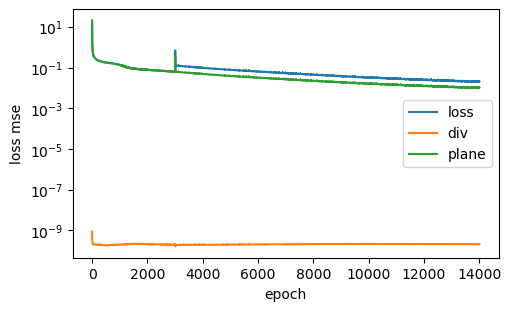

In [438]:
n_epochs = 10000
for i in range(n_epochs):
    [key] = jax.random.split(key,1)
    l_epoch = {'loss':[], 'div':[], 'plane':[]}
    j = 0
    while (j+1)*50 <= n_train :
        _inns3 = (jnp.einsum('txyzu -> tzxyu', predv1)[j*50:(j+1)*50,...], jnp.einsum('tyz -> tzy', inns_norm)[j*50:(j+1)*50,...], z_coord)
        (_l, _l_components), state3 = update3(state3, key, _inns3, y[j*50:(j+1)*50,...])
        j += 1
        l_epoch['loss'].append(float(_l))
        for k,a in _l_components.items():
            l_epoch[k].append(float(a))
    for k,a in l_epoch.items():
        hist3[k].append(np.mean(a))
    if i % 20 == 0:
        print(f'epoch {i}, ', " ".join(f"{k}: {a[-1]:.5f}" for k, a in hist3.items()))
    if hist3['loss'][-1] < best_l:
        best_state3 = state3
        best_l = hist3['loss'][-1]
plt.figure(figsize=(5,3))
for k in hist3.keys():
    plt.semilogy(hist3[k], label=k)
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss mse')
plt.show()

In [439]:
predv3 = mdl3_apply(best_state3.params, None, *inns3_group)
# predv3_norm = np.einsum('tzxyu -> txyzu', predv3_norm)
print(f'volume mse {losses.relative_error(predv3,u_train[...,:-1])}, measured plane {losses.relative_error(predv3[:,:,:,z_plane,:],u_train[:,:,:,z_plane,:-1])}')
for i in range(0,z_plane):
    print(losses.relative_error(predv3[:,:,:,i,:],u_train[:,:,:,i,:-1]))
# predv3 = unnormalise_group(predv3_norm, data_range=y_range, axis_data=-1, axis_range=0)
print(f'Divergence {losses.divergence(predv3,datainfo)}')

volume mse 2.720526695251465, measured plane 0.8506906032562256
3.4710774
3.3169537
2.8815649
2.663919
2.4309602
2.2075665
1.9482071
1.6949334
1.4647965
1.2127931
Divergence 1.814280392586909e-10


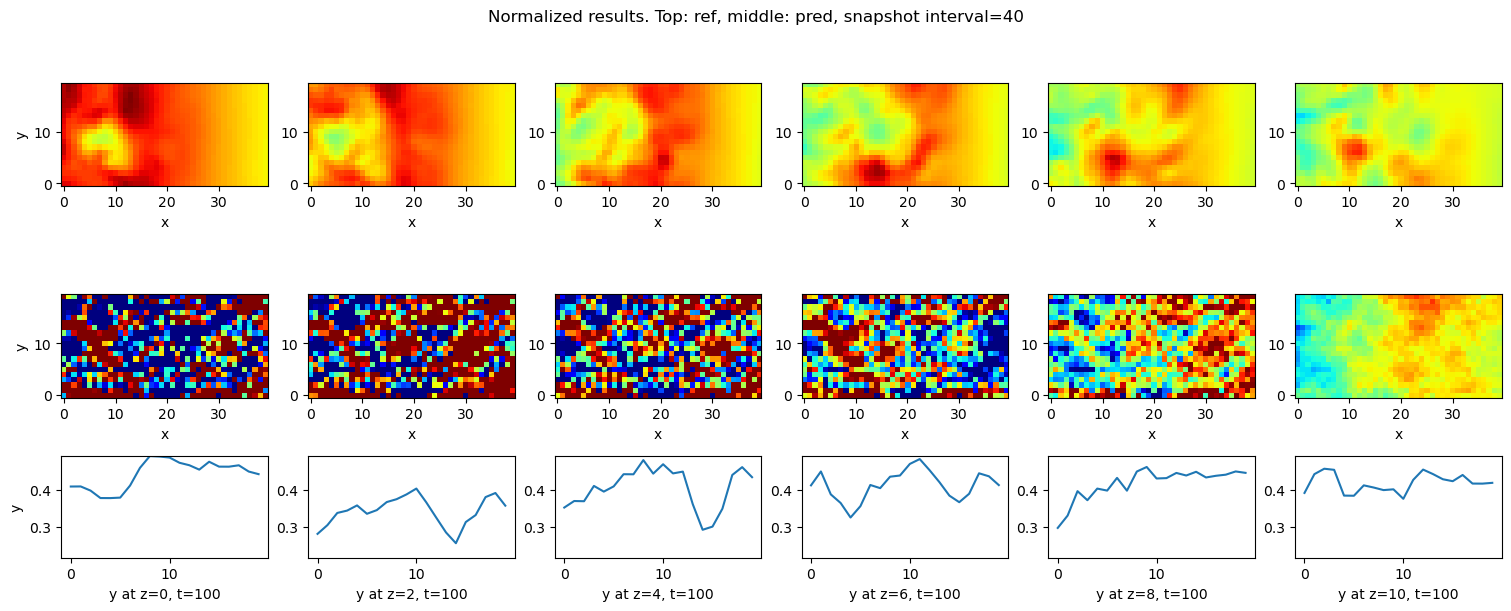

In [440]:
plt_zgap = 2
plt_t = 100
vmin = u_train[plt_t,...,::plt_zgap,0].min()
vmax = u_train[plt_t,...,::plt_zgap,0].max()
fig,axes = plt.subplots(3,6,figsize=(15,6),height_ratios=(0.4,0.4,0.2))
fig.suptitle(f'Normalized results. Top: ref, middle: pred, snapshot interval={plt_step}')
for i in range(6):
    axes[2,i].plot(inns_norm[plt_t,:,i*plt_zgap])
    axes[2,i].set(xlabel=f'y at z={i*plt_zgap}, t={plt_t}', ylim=[inns_norm[plt_t,:,::plt_zgap].min(), inns_norm[plt_t,:,::plt_zgap].max()])
    axes[0,i].imshow(u_train[plt_t,:,:,i*plt_zgap,0].T, vmin=vmin, vmax=vmax)
    axes[0,i].set(xlabel='x')
    axes[1,i].imshow(predv3[plt_t,:,:,i*plt_zgap,0].T, vmin=vmin, vmax=vmax)
    axes[1,i].set(xlabel='x')
axes[0,0].set_ylabel('y')
axes[1,0].set_ylabel('y')
axes[2,0].set_ylabel('y')
plt.show()

### try a different set up

In [314]:
def forward3_1(p,z_coord):
    _mlp = MLP(
        [128,256, 512, 1024,y[0,...].size],
        name='mlp',
        w_init=hk.initializers.VarianceScaling(1.0,'fan_avg','uniform'),
        activation=jax.nn.tanh
        )
    # linear_z = hk.Linear(y[0,...].size,with_bias=False,name='linear_correction')
    
    linear_p = hk.Linear(y[0,...].size,with_bias=False,name='linear_correction_pressure')
    linear_z = hk.Linear(20,with_bias=False,name='linear_correction')

    # apply to all z
    def inner(p1,z1):
        # print(p1.shape)
        out1 = _mlp(p1, TRAINING=True)
        # combine
        # correction = linear_z(z1) # correct only with z
        
        # correct with both pressure and z
        correctionz = linear_z(z1)
        p2 = jnp.einsum('zi,zi -> zi', p1, correctionz) # zero if z is 0 
        correction = linear_p(p2)
        return out1 + correction
    
    # apply over all time
    # print(p.shape)
    volume_over_time = jax.vmap(inner, (0,None), 0)
    return volume_over_time(p,z_coord)

mdl3_1 = hk.transform(forward3_1)
_p = mdl3_1.init(key, jnp.einsum('txz -> tzx', inns_norm[:10,...]), jnp.reshape(z_coord, (20,1)))
print(list(_p))
# print(mdl3_1.apply(_p,None, jnp.einsum('txz -> tzx', inns_norm[:10,...]), jnp.reshape(z_coord, (20,1))).shape)
print(mdl3_1.apply(_p,None, jnp.einsum('txz -> tzx', inns_norm[:10,:,[10]]), jnp.reshape(np.array([0]), (1,1))).shape)

['mlp/~/linear_0', 'mlp/~/linear_1', 'mlp/~/linear_2', 'mlp/~/linear_3', 'mlp/~/linear_4', 'linear_correction', 'linear_correction_pressure']
(10, 1, 2400)


In [342]:
## split weights
for k, layer in best_state1.params.items():
    if k in _p.keys():
        _p[k].update(layer)
        # print(k, layer.keys())
print(np.allclose(_p['mlp/~/linear_0']['w'], best_state1.params['mlp/~/linear_0']['w']))
params3_trainable, params3_non_trainable = hk.data_structures.partition(
    lambda module_name, name, value: 'correction' in module_name or module_name=='mlp/~/linear_4'or module_name=='mlp/~/linear_3',
    _p
)
print(list(params3_trainable), list(params3_non_trainable))
print(jax.tree_map(lambda x: print(x.shape),params3_trainable))


True
['linear_correction', 'linear_correction_pressure', 'mlp/~/linear_3', 'mlp/~/linear_4'] ['mlp/~/linear_0', 'mlp/~/linear_1', 'mlp/~/linear_2']
(1, 20)
(20, 2400)
(1024,)
(512, 1024)
(2400,)
(1024, 2400)
{'linear_correction': {'w': None}, 'linear_correction_pressure': {'w': None}, 'mlp/~/linear_3': {'b': None, 'w': None}, 'mlp/~/linear_4': {'b': None, 'w': None}}


In [343]:
lr = 0.001
scheduler3_1 = optimiser_options.get_scheduler('exponential_decay', lr)
optimiser3_1 = optax.adamw(learning_rate=scheduler3_1)
opt_state3_1 = optimiser3_1.init(params3_trainable)
state3_1 = train.TrainingState(params=params3_trainable, opt_state=opt_state3_1)
mdl3_1.apply(
    hk.data_structures.merge(state3_1.params,params3_non_trainable),
    key, 
    jnp.einsum('txz -> tzx', inns_norm[:10,...]), 
    jnp.reshape(z_coord, (20,1))
).shape

(10, 20, 2400)

In [344]:
inns3_1_group = (
    jnp.einsum('txz -> tzx', inns_norm[:,...]), 
    jnp.reshape(z_coord, (20,1))
)

In [38]:
def relative_error(pred,true):
    err = jnp.sqrt(
        jnp.sum((pred-true)**2)
        / jnp.sum(true**2)
    )
    return err

In [368]:
def loss3_1(apply_fn, trainable, rng, inns_group, y, non_trainable):
    # merge all params
    params = hk.data_structures.merge(trainable, non_trainable)
    
    pred = apply_fn(params, rng, *inns_group)
    pred = jnp.reshape(pred, (-1,20,)+y.shape[1:])
    pred = jnp.einsum('tzxyu -> txyzu', pred)
    ld = relative_error(pred[:,:,:,z_plane,:], y) # take data loss before unnormalising
    pred_new = pred.at[:,:,:,z_plane,:].set(y)
    ## unnormalise because div(u) is not div(normalised(u))
    pred_new = unnormalise_group(pred_new, data_range=y_range, axis_data=-1, axis_range=0)
    ldiv = losses.divergence(pred_new, datainfo)
    return 10*ld + ldiv, {'plane': ld, 'div':ldiv}


update3_1 = train.generate_update_fn(
    mdl3_1.apply,
    optimiser3_1,
    loss3_1,
    kwargs_loss={'non_trainable': params3_non_trainable},
    kwargs_value_and_grad={'has_aux':True}
)
l,_ = update3_1(state3_1, key, inns3_1_group, y_norm)
print(l)

(Array(7.227336, dtype=float32), {'div': Array(3.9648972, dtype=float32), 'plane': Array(0.32624388, dtype=float32)})


In [369]:
hist3_1 = {'loss':[], 'div':[], 'plane':[]}
best_l = np.inf

epoch 0,  loss: 5.81529 div: 3.57192 plane: 0.22434
epoch 20,  loss: 5.74801 div: 3.51587 plane: 0.22321
epoch 40,  loss: 5.92633 div: 3.67908 plane: 0.22473
epoch 60,  loss: 6.32881 div: 4.02241 plane: 0.23064
epoch 80,  loss: 6.07942 div: 3.82019 plane: 0.22592
epoch 100,  loss: 6.35636 div: 4.07166 plane: 0.22847
epoch 120,  loss: 6.22161 div: 3.95189 plane: 0.22697
epoch 140,  loss: 6.48704 div: 4.19877 plane: 0.22883
epoch 160,  loss: 6.26837 div: 3.99509 plane: 0.22733
epoch 180,  loss: 5.91039 div: 3.67243 plane: 0.22380
epoch 200,  loss: 5.74478 div: 3.52375 plane: 0.22210
epoch 220,  loss: 5.88279 div: 3.64818 plane: 0.22346
epoch 240,  loss: 6.02632 div: 3.78314 plane: 0.22432
epoch 260,  loss: 6.06299 div: 3.81573 plane: 0.22473
epoch 280,  loss: 5.79428 div: 3.56028 plane: 0.22340
epoch 300,  loss: 5.97358 div: 3.71837 plane: 0.22552
epoch 320,  loss: 5.72744 div: 3.49627 plane: 0.22312
epoch 340,  loss: 5.68840 div: 3.44765 plane: 0.22407
epoch 360,  loss: 5.95080 div: 3.6

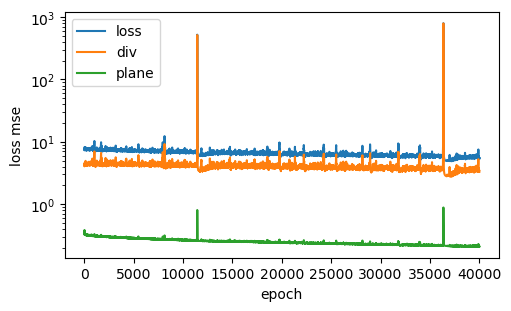

In [382]:
n_epochs = 10000
batch = 100
for i in range(n_epochs):
    [key] = jax.random.split(key,1)
    l_epoch = {'loss':[], 'div':[], 'plane':[]}
    j = 0
    while (j+1)*batch <= n_train :
        _inns3_1 = (
            jnp.einsum('txz -> tzx', inns_norm[j*batch:(j+1)*batch,...]), 
            jnp.reshape(z_coord, (20,1))
        )
        (_l, _l_components), state3_1 = update3_1(state3_1, key, _inns3_1, y_norm[j*batch:(j+1)*batch,...])
        j += 1
        l_epoch['loss'].append(float(_l))
        for k,a in _l_components.items():
            l_epoch[k].append(float(a))
    for k,a in l_epoch.items():
        hist3_1[k].append(np.mean(a))
    if i % 20 == 0:
        print(f'epoch {i}, ', " ".join(f"{k}: {a[-1]:.5f}" for k, a in hist3_1.items()))
    if hist3_1['loss'][-1] < best_l:
        best_state3_1 = state3_1
        best_l = hist3_1['loss'][-1]
plt.figure(figsize=(5,3))
for k in hist3_1.keys():
    plt.semilogy(hist3_1[k], label=k)
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss mse')
plt.show()

In [383]:
predv3_1_norm = mdl3_1.apply(
    hk.data_structures.merge(best_state3_1.params,params3_non_trainable),
    None, 
    *inns3_1_group).reshape((-1,20,)+y.shape[1:])
predv3_1_norm = np.einsum('tzxyu -> txyzu', predv3_1_norm)
print(f'volume relative error {losses.relative_error(predv3_1_norm,refvelocity_norm)}, measured plane {losses.relative_error(predv3_1_norm[:,:,:,z_plane,:],refvelocity_norm[:,:,:,z_plane,:])}')
for i in range(0,z_plane+1):
    print(losses.relative_error(predv3_1_norm[:,:,:,i,:],refvelocity_norm[:,:,:,i,:]))
predv3_1 = unnormalise_group(predv3_1_norm, data_range=y_range, axis_data=-1, axis_range=0)
print(f'Divergence {losses.divergence(predv3_1,datainfo)}')

volume relative error 1.130313406947568, measured plane 0.21060410381005903
0.9831308996838527
0.9603092611389394
0.9645408343699347
0.993705397368086
1.0092638679899282
1.0194026853701368
1.0144247629771066
0.9907431491633835
0.8927284219993349
0.7921428115727838
0.21060410381005903
Divergence 2.122666597366333


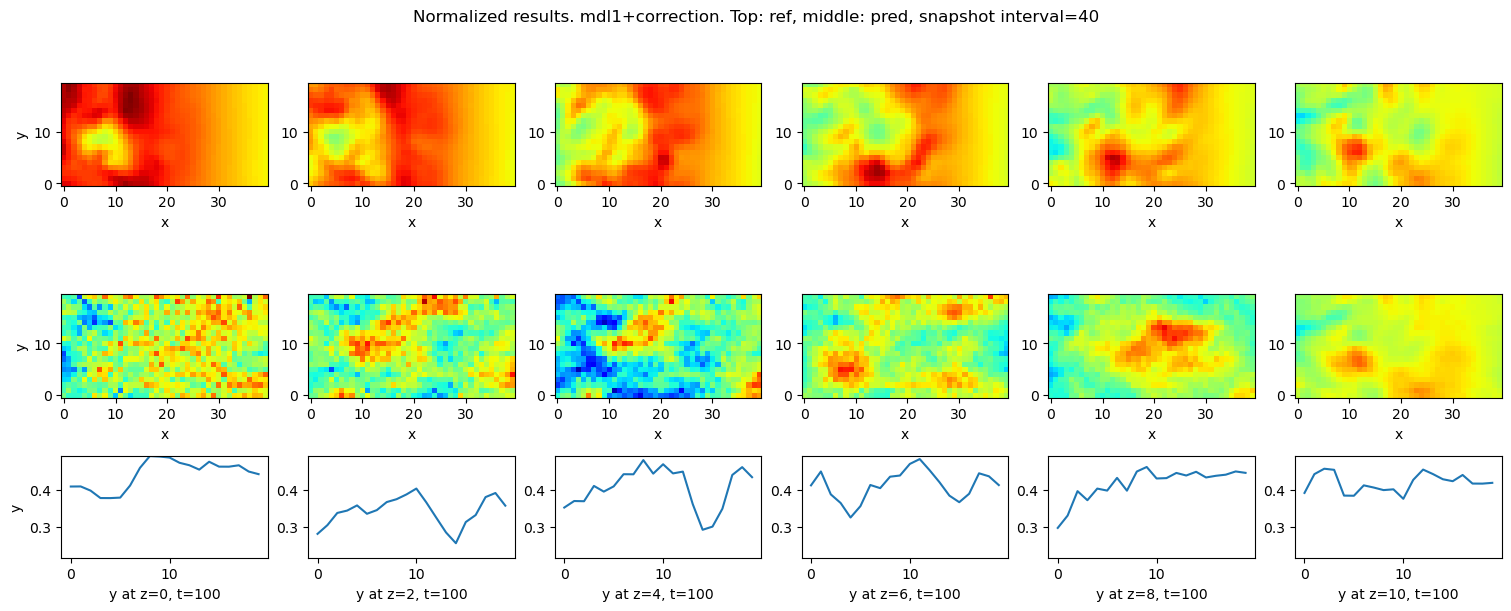

In [384]:
plt_zgap = 2
plt_t = 100
vmin = refvelocity_norm[plt_t,...,::plt_zgap,0].min()
vmax = refvelocity_norm[plt_t,...,::plt_zgap,0].max()
fig,axes = plt.subplots(3,6,figsize=(15,6),height_ratios=(0.4,0.4,0.2))
fig.suptitle(f'Normalized results. mdl1+correction. Top: ref, middle: pred, snapshot interval={plt_step}')
for i in range(6):
    axes[2,i].plot(inns_norm[plt_t,:,i*plt_zgap])
    axes[2,i].set(xlabel=f'y at z={i*plt_zgap}, t={plt_t}', ylim=[inns_norm[plt_t,:,::plt_zgap].min(), inns_norm[plt_t,:,::plt_zgap].max()])
    axes[0,i].imshow(refvelocity_norm[plt_t,:,:,i*plt_zgap,0].T, vmin=vmin, vmax=vmax)
    axes[0,i].set(xlabel='x')
    axes[1,i].imshow(predv3_1_norm[plt_t,:,:,i*plt_zgap,0].T, vmin=vmin, vmax=vmax)
    axes[1,i].set(xlabel='x')
axes[0,0].set_ylabel('y')
axes[1,0].set_ylabel('y')
axes[2,0].set_ylabel('y')
plt.show()

# Try adding pressure straight away MDL2

In [30]:
def forward2(p,z_coord):
    final_size = y[0,...].size
    _mlp = MLP(
        [128,256,512,1024,final_size],
        name='mlp',
        w_init=hk.initializers.VarianceScaling(1.0),
        activation=jax.nn.tanh
    )
    linear_z = [hk.Linear(512, with_bias=False), hk.Linear(final_size, with_bias=False)]
    linear_reduce = [hk.Linear(n) for n in [512,128]]
    linear_p = [hk.Linear(n) for n in [128,512,1024,int(final_size/3)]]

    def over_z(p1,z1):
        u = _mlp(p1, TRAINING=True)
        correction = z1
        for l in linear_z:
            correction = jax.nn.tanh(correction)
            correction = l(correction)
        u = u + correction
        u_reduce = u 
        for l in linear_reduce:
            u_reduce = jax.nn.tanh(u_reduce)
            u_reduce = l(u_reduce)
        outp = jnp.concatenate((p1,z1,u_reduce),axis=-1)
        for l in linear_p:
            outp = jax.nn.tanh(outp)
            outp = l(outp)
        outu = jnp.reshape(u, (-1,40,20,3))
        outp = jnp.reshape(outp, (-1,40,20,1))
        return jnp.concatenate((outu,outp), axis=-1)

    out = jax.vmap(over_z, (0,None),0)(p,z_coord)
    out = jnp.einsum('tzxyu -> txyzu', out)
    return out
mdl2 = hk.transform(forward2)
params2 = mdl2.init(key,  jnp.einsum('txz -> tzx', inns_norm[:10,...]), jnp.reshape(z_coord, (20,1)))
print(list(params2))
print(mdl2.apply(params2, None, jnp.einsum('txz -> tzx', inns_norm[:10,...]), jnp.reshape(z_coord, (20,1))).shape)

['mlp/~/linear_0', 'mlp/~/linear_1', 'mlp/~/linear_2', 'mlp/~/linear_3', 'mlp/~/linear_4', 'linear', 'linear_1', 'linear_2', 'linear_3', 'linear_4', 'linear_5', 'linear_6', 'linear_7']
(10, 40, 20, 20, 4)


In [96]:
## split weights
for k, layer in best_state1.params.items():
    if k in params2.keys():
        params2[k].update(layer)
        # print(k, layer.keys())
print(np.allclose(params2['mlp/~/linear_0']['w'], best_state1.params['mlp/~/linear_0']['w']))
params2_non_trainable, params2_trainable = hk.data_structures.partition(
    lambda module_name, name, value: module_name in ['mlp/~/linear_0', 'mlp/~/linear_1', 'mlp/~/linear_2', 'mlp/~/linear_3',],
    params2
)
print(list(params2_trainable))
print(list(params2_non_trainable))
print(jax.tree_map(lambda x: print(x.shape),params2_trainable))

True
['linear', 'linear_1', 'linear_2', 'linear_3', 'linear_4', 'linear_5', 'linear_6', 'linear_7', 'mlp/~/linear_4']
['mlp/~/linear_0', 'mlp/~/linear_1', 'mlp/~/linear_2', 'mlp/~/linear_3']
(1, 512)
(512, 2400)
(512,)
(2400, 512)
(128,)
(512, 128)
(128,)
(149, 128)
(512,)
(128, 512)
(1024,)
(512, 1024)
(800,)
(1024, 800)
(2400,)
(1024, 2400)
{'linear': {'w': None}, 'linear_1': {'w': None}, 'linear_2': {'b': None, 'w': None}, 'linear_3': {'b': None, 'w': None}, 'linear_4': {'b': None, 'w': None}, 'linear_5': {'b': None, 'w': None}, 'linear_6': {'b': None, 'w': None}, 'linear_7': {'b': None, 'w': None}, 'mlp/~/linear_4': {'b': None, 'w': None}}


In [97]:
lr = 0.001
scheduler2 = optimiser_options.get_scheduler('exponential_decay', lr)
optimiser2 = optax.adamw(learning_rate=scheduler2)
opt_state2 = optimiser2.init(params2_trainable)
state2 = train.TrainingState(params=params2_trainable, opt_state=opt_state2)
print(mdl2.apply(
    hk.data_structures.merge(state2.params,params2_non_trainable),
    key, 
    jnp.einsum('txz -> tzx', inns_norm[:10,...]), 
    jnp.reshape(z_coord, (20,1))
).shape)
inns2_group = (
    jnp.einsum('txz -> tzx', inns_norm[:,...]), 
    jnp.reshape(z_coord, (20,1))
)

(10, 40, 20, 20, 4)


In [133]:
def loss2(apply_fn, trainable, rng, inns_group, yall, non_trainable):
    params = hk.data_structures.merge(trainable, non_trainable)
    pred = apply_fn(params, rng, *inns_group)
    print(pred.shape)
    ld = losses.mse(pred[:,:,:,z_plane,0], yall[:,:,:,z_plane,0]) #+ losses.mse(pred[inns_loc],yall[inns_loc]) # data loss, velocities on the plane and pressure at inlet
    pred_new = pred.at[:,:,:,z_plane,:-1].set(yall[:,:,:,z_plane,:-1])
    pred_new = pred_new.at[inns_loc].set(yall[inns_loc])
    # unnormalise before taking physics loss
    pred_new = unnormalise_group(pred_new, data_range=all_range, axis_data=-1, axis_range=0)
    ldiv = losses.divergence(pred_new[...,:-1], datainfo)
    lmom = losses.momentum_loss(pred_new, datainfo)
    # Poisson equation for incompressible flow
    # lp = 
    
    return 1000*ld + 200*ldiv + lmom, {'plane': ld, 'div':ldiv, 'momentum':lmom}

update2 = train.generate_update_fn(
    mdl2.apply,
    optimiser2,
    loss2,
    kwargs_loss={'non_trainable': params2_non_trainable},
    kwargs_value_and_grad={'has_aux':True}
)
l,_ = update2(state2, key, inns2_group, u_train_norm)
print(l)

(200, 40, 20, 20, 4)
(Array(3706.6956, dtype=float32), {'div': Array(17.97694, dtype=float32), 'momentum': Array(105.93866, dtype=float32), 'plane': Array(0.00536924, dtype=float32)})


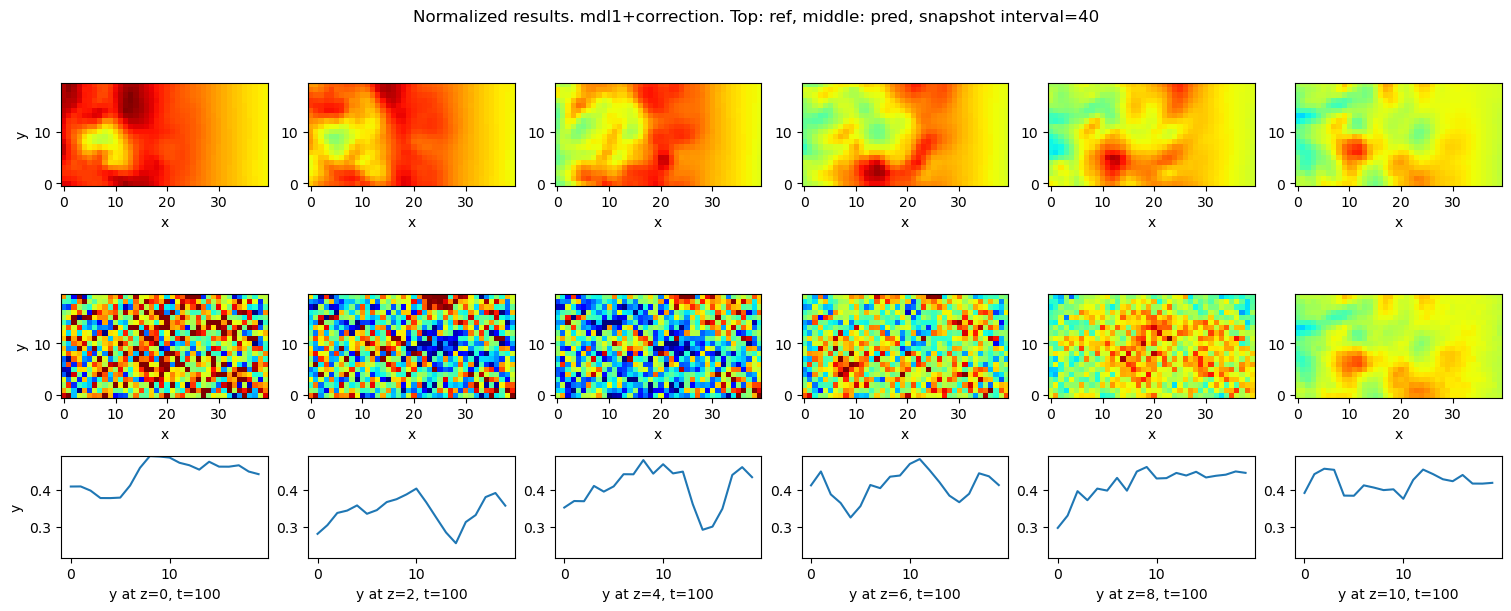

In [111]:
predv2_norm = mdl2.apply(
    hk.data_structures.merge(params2),
    None, 
    *inns2_group
)
plt_zgap = 2
plt_t = 100
vmin = refvelocity_norm[plt_t,...,::plt_zgap,0].min()
vmax = refvelocity_norm[plt_t,...,::plt_zgap,0].max()
fig,axes = plt.subplots(3,6,figsize=(15,6),height_ratios=(0.4,0.4,0.2))
fig.suptitle(f'Normalized results. mdl1+correction. Top: ref, middle: pred, snapshot interval={plt_step}')
for i in range(6):
    axes[2,i].plot(inns_norm[plt_t,:,i*plt_zgap])
    axes[2,i].set(xlabel=f'y at z={i*plt_zgap}, t={plt_t}', ylim=[inns_norm[plt_t,:,::plt_zgap].min(), inns_norm[plt_t,:,::plt_zgap].max()])
    axes[0,i].imshow(refvelocity_norm[plt_t,:,:,i*plt_zgap,0].T, vmin=vmin, vmax=vmax)
    axes[0,i].set(xlabel='x')
    axes[1,i].imshow(predv2_norm[plt_t,:,:,i*plt_zgap,0].T, vmin=vmin, vmax=vmax)
    axes[1,i].set(xlabel='x')
axes[0,0].set_ylabel('y')
axes[1,0].set_ylabel('y')
axes[2,0].set_ylabel('y')
plt.show()

In [103]:
hist2 = {'loss':[], 'plane':[], 'div':[], 'momentum':[]}
best_l = np.inf

(100, 40, 20, 20, 4)
epoch 0,  loss: 4681.78601 plane: 0.00542 div: 22.83294 momentum: 109.77829
epoch 20,  loss: 2798.29834 plane: 0.00538 div: 13.44962 momentum: 102.99873
epoch 40,  loss: 2782.28442 plane: 0.00544 div: 13.37148 momentum: 102.54426
epoch 60,  loss: 2781.66479 plane: 0.00551 div: 13.36963 momentum: 102.22525
epoch 80,  loss: 2781.44324 plane: 0.00558 div: 13.36959 momentum: 101.94359
epoch 100,  loss: 2781.29187 plane: 0.00565 div: 13.36975 momentum: 101.68960
epoch 120,  loss: 2781.09985 plane: 0.00572 div: 13.36960 momentum: 101.45800
epoch 140,  loss: 2781.01501 plane: 0.00579 div: 13.36961 momentum: 101.30050
epoch 160,  loss: 2780.86487 plane: 0.00586 div: 13.36939 momentum: 101.12547
epoch 180,  loss: 2780.67505 plane: 0.00593 div: 13.36939 momentum: 100.86771
epoch 200,  loss: 2780.50195 plane: 0.00600 div: 13.36921 momentum: 100.66243
epoch 220,  loss: 2780.40564 plane: 0.00606 div: 13.36911 momentum: 100.52152
epoch 240,  loss: 2780.28369 plane: 0.00613 div: 

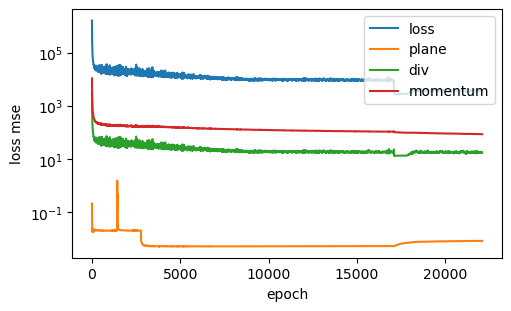

In [134]:
n_epochs = 5000
batch = 100
for i in range(n_epochs):
    [key] = jax.random.split(key,1)
    l_epoch = {'loss':[], 'div':[], 'plane':[], 'momentum':[]}
    j = 0
    while (j+1)*batch <= n_train :
        _inns2 = (
            jnp.einsum('txz -> tzx', inns_norm[j*batch:(j+1)*batch,...]), 
            jnp.reshape(z_coord, (20,1))
        )
        (_l, _l_components), state2 = update2(state2, key, _inns2, u_train_norm[j*batch:(j+1)*batch,...])
        j += 1
        l_epoch['loss'].append(float(_l))
        for k,a in _l_components.items():
            l_epoch[k].append(float(a))
    for k,a in l_epoch.items():
        hist2[k].append(np.mean(a))
    if i % 20 == 0:
        print(f'epoch {i}, ', " ".join(f"{k}: {a[-1]:.5f}" for k, a in hist2.items()))
    if hist2['loss'][-1] < best_l:
        best_state2 = state2
        best_l = hist2['loss'][-1]
plt.figure(figsize=(5,3))
for k in hist2.keys():
    plt.semilogy(hist2[k], label=k)
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss mse')
plt.show()

In [135]:
predv2_norm = mdl2.apply(
    hk.data_structures.merge(best_state2.params,params2_non_trainable),
    None, 
    *inns2_group)
print(f'volume relative error {losses.relative_error(predv2_norm,u_train_norm)}, measured plane {losses.relative_error(predv2_norm[:,:,:,z_plane,:],u_train_norm[:,:,:,z_plane,:])}')
for i in range(0,z_plane+1):
    print(losses.relative_error(predv2_norm[:,:,:,i,:],u_train_norm[:,:,:,i,:]))
predv2 = unnormalise_group(predv2_norm, data_range=all_range, axis_data=-1, axis_range=0)
print(f'Divergence {losses.divergence(predv2[...,:-1],datainfo)}')

volume relative error 45.62825012207031, measured plane 52.09854507446289
33.228672
32.19792
31.74607
32.611397
33.41094
34.99105
36.281193
38.37084
40.432926
43.780453
52.098545
Divergence 4.858890056610107


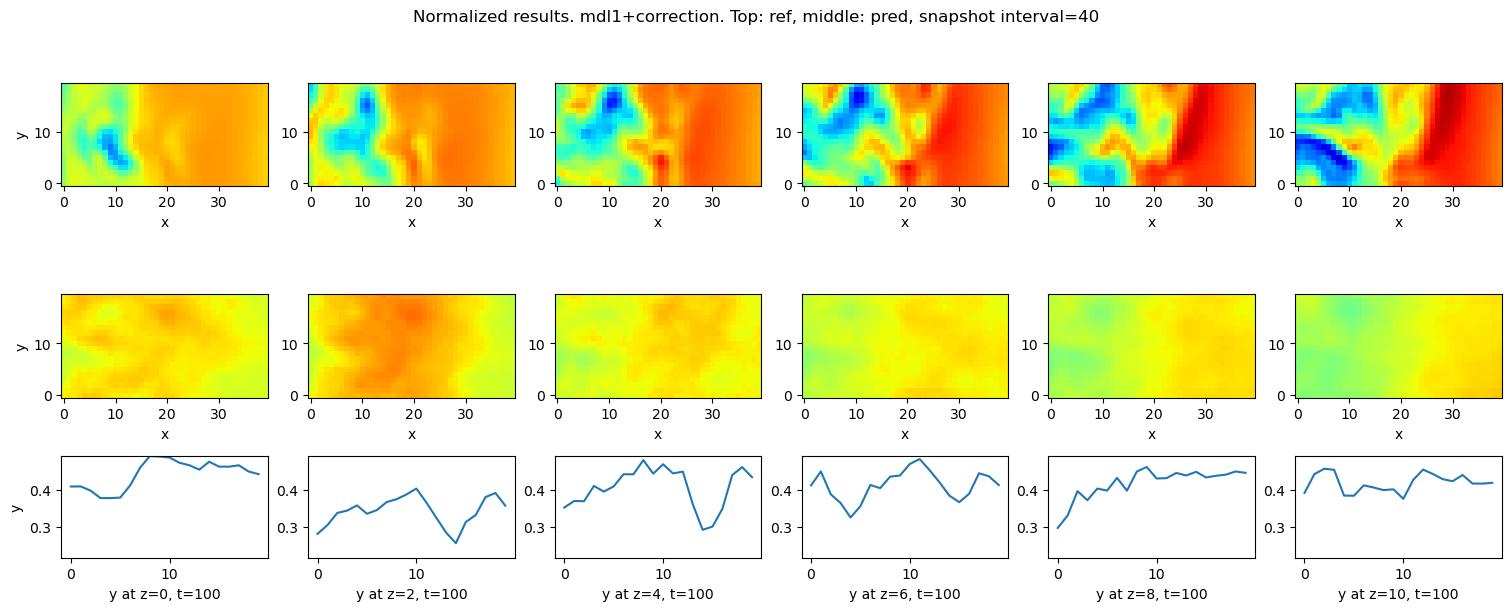

In [143]:
plt_zgap = 2
plt_t = 100
which_component = 2
vmin = u_train_norm[plt_t,...,::plt_zgap,which_component].min()
vmax = u_train_norm[plt_t,...,::plt_zgap,which_component].max()
fig,axes = plt.subplots(3,6,figsize=(15,6),height_ratios=(0.4,0.4,0.2))
fig.suptitle(f'Normalized results. mdl1+correction. Top: ref, middle: pred, snapshot interval={plt_step}')
for i in range(6):
    axes[2,i].plot(inns_norm[plt_t,:,i*plt_zgap])
    axes[2,i].set(xlabel=f'y at z={i*plt_zgap}, t={plt_t}', ylim=[inns_norm[plt_t,:,::plt_zgap].min(), inns_norm[plt_t,:,::plt_zgap].max()])
    axes[0,i].imshow(u_train_norm[plt_t,:,:,i*plt_zgap,which_component].T, vmin=vmin, vmax=vmax)
    axes[0,i].set(xlabel='x')
    axes[1,i].imshow(predv2_norm[plt_t,:,:,i*plt_zgap,which_component].T, vmin=vmin, vmax=vmax)
    axes[1,i].set(xlabel='x')
axes[0,0].set_ylabel('y')
axes[1,0].set_ylabel('y')
axes[2,0].set_ylabel('y')
plt.show()

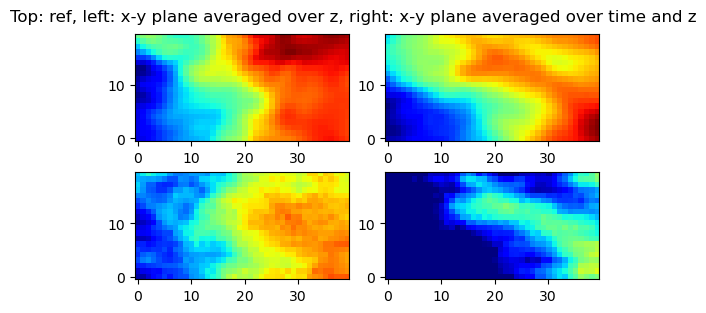

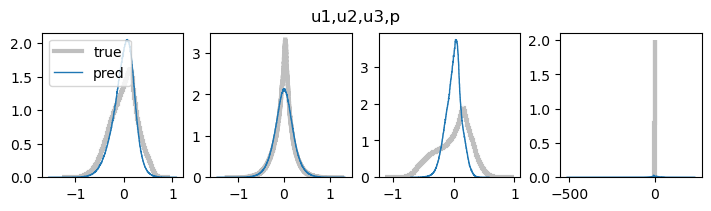

In [165]:
plt_t = 170
which_component = 0
fig, axes = plt.subplots(2, 2, figsize=(5,3))
imref = axes[0,0].imshow(np.mean(u_train_norm[plt_t,:,:,:,which_component], axis=2).T)
vmin, vmax = imref.get_clim()
axes[1,0].imshow(np.mean(predv2_norm[plt_t,:,:,:,which_component], axis=2).T, vmax=vmax, vmin=vmin)

imref = axes[0,1].imshow(np.mean(u_train_norm[:,:,:,:,which_component], axis=(0,3)).T)
vmin, vmax = imref.get_clim()
axes[1,1].imshow(np.mean(predv2_norm[:,:,:,:,which_component], axis=(0,3)).T, vmax=vmax, vmin=vmin)
fig.suptitle('Top: ref, left: x-y plane averaged over z, right: x-y plane averaged over time and z')
plt.show()

fig, axes = plt.subplots(1,4, figsize=(7,2))
for i,ax in enumerate(axes):
    counts_true,bins_true = np.histogram(u_train_norm[...,i].flatten()-np.mean(u_train_norm[...,i].flatten()), density=True, bins='auto')
    ax.stairs(counts_true,bins_true,label='true',linewidth=3, color='#808080',alpha=0.5)
    counts,bins= np.histogram(predv2_norm[...,i].flatten()-np.mean(predv2_norm[...,i].flatten()), density=True, bins='auto')
    ax.stairs(counts,bins,label='pred')
axes[0].legend()
fig.suptitle('u1,u2,u3,p')
plt.show()